# Modeling Exoplanet Spectra
Part 2 of the [Primer on Exoplanets and JWST](https://github.com/Kappibw/JWST) series.

## Who is this tutorial for?

People that
- Have some programming know-how (basic python is fine!)
- *Don't* necessarily have an education/ experience in astronomy/astrophysics
- Are excited about JWST's potential to tell us about planets outside our solar system!

## What does this tutorial cover?

A concrete walk-through of what it takes to model exoplanet spectra, in order to compare it to observed spectra from JWST, specifically:
- Understanding the components needed to model an synthetic exoplanet
- Using PICASO, an exoplanet modeling software
- Modeling WASP-39 b, the first exoplanet [JWST confirmed has CO2 in its atmosphere](https://www.nasa.gov/feature/goddard/2022/nasa-s-webb-detects-carbon-dioxide-in-exoplanet-atmosphere).

## What should you know going in?

- [Part 1]() of the Primer on Exoplanets and JWST series - Retrieving Exoplanet Spectra from the James Webb Space Telescope

# 1. Set Up

## Jupyter
In order to follow along with this tutorial in place, you will need to be able to run Jupyter notebooks (install from [here](https://jupyter.org/install)). Then you can download this notebook from git and open it in Jupyter.

In [266]:
#run this cell in place once you have Juypyter up and running.
print("hello JWST!")
import matplotlib.pyplot as plt

hello JWST!


## PICASO
Then, you'll need the python libraries used for astronomy. [PICASO](https://natashabatalha.github.io/picaso/index.html) is a python toolkit for modeling exoplanet spectroscopy, and it is dependent on several other astronomy libraries, like [astropy](https://www.astropy.org/). That means just installing PICASO should give you the other packages you need.

PICASO installation instructions are [here](https://natashabatalha.github.io/picaso/installation.html). Note that part of the setup is downloading a very large (6GB) reference database.

Once you've installed PICASO, use the following to check it is set up as expected.

In [267]:
#check you have picaso
from picaso import justdoit as jdi 
from picaso import justplotit as jpi
import picaso.opacity_factory as op
import numpy as np

jpi.output_notebook()

Loading BokehJS ...

In [268]:
#double check that your reference file path has been set 
import os
refdata = os.getenv("picaso_refdata")
print(refdata)
#if you are having trouble setting this you can do it right here in the command line
#os.environ["picaso_refdata"]= add your path here AND COPY AND PASTE ABOVE 
#IT WILL NEED TO GO ABOVE YOUR PICASO IMPORT

/Users/kappi/Documents/space/PICASO/reference/


# 2. Introduction

<img src="https://drive.google.com/uc?id=1ekTkENEFgAJV5PyTw2_AQKPm-fCJizGq">

A spectrum of an exoplanet's atmosphere, like the one above that [NASA published of WASP-39 b](https://www.nasa.gov/feature/goddard/2022/nasa-s-webb-detects-carbon-dioxide-in-exoplanet-atmosphere), gives you information about what wavelengths of light were absorbed more than others by the planet you're observing. For a refresher see the quick spectroscopy 101 articles [here](https://webbtelescope.org/contents/articles/spectroscopy-101--introduction).

Each molecule absorbs light at unique wavelengths. You might be an expert and be able to see just by observation that some of the peaks correspond to, say, the presence of carbon dioxide, but the spectrum will likely be much more complex than just an absorption pattern for a single molecule. Also, there are several factors that can "distort" the spectrum, such as overlapping absorption from multiple molecules, or the effect of clouds.

### Fancy "Guess and Check"
So, looking at a raw spectrum with complex features, how do you make statements about what the planet's atmosphere is composed of? One method (that we are exploring here) is to create our own physically-motivated spectra of exoplanets and compare those to what we have observed. By matching these patterns we can start to infer real properties of exoplanet atmospheres.

For example, you might compute what the spectrum of a planet with x% water and y% hydrogen in its atmosphere would look like and see how similar it is to the observation.

We are going to build up a physical-model of an exoplanet, and try to get it to match the observed WASP-39 b spectrum. Hopefully, the components of our model will then tell us about the atmospheric composition of WASP-39 b (even though we are cheating a bit because we already know the presence of CO2 was big news in this spectrum).

# 3. Observed Spectrum

Before we start modeling a planet to match WASP-39 b, let's get hold of WASP-39 b's actual observed spectrum in data format, so we can plot it next to our modeled ones. If you did [part 1 of this tutorial](https://github.com/Kappibw/JWST/blob/main/2_retrieving_jwst_spectra.ipynb), you already downloaded the data prepared by the scientists who wrote [the CO2 discovery paper](https://arxiv.org/pdf/2208.11692.pdf). 

If you haven't done part 1, you can download the data from [here](https://zenodo.org/record/6959427#.Yx936-zMJqv). Download the .zip, and then look for `ZENODO/TRANSMISSION_SPECTRA_DATA/EUREKA_REDUCTION.txt`.

In [269]:
from astropy.io import ascii
# This will work if you are using conda and put the downloaded folder in your current env top folder. Feel
# free to change this if you used a different system.
eureka_reduction_path = os.getenv("CONDA_PREFIX") + '/ZENODO/TRANSMISSION_SPECTRA_DATA/EUREKA_REDUCTION.txt'
observed_data = ascii.read(eureka_reduction_path)

In [270]:
observed_data.colnames

['wavelength',
 'bin_width',
 'tr_depth',
 'tr_depth_errneg',
 'tr_depth_errpos',
 'ecl_depth',
 'ecl_depth_errneg',
 'ecl_depth_errpos']

## Transit Depth
`tr_depth` is "transit depth" which is confusingly named in my opinion but means "how much of the host star's light was blocked". When we plot the amount of light received (flux) over time from a star, and a planet passes in front of it, we call the graph of the dip in starlight a "light curve". The dip in the graph is "deeper" the bigger the apparent size of the planet is, giving it a bigger "transit depth". Below is a typical light curve:

<img src="https://drive.google.com/uc?id=1h4DsDWSjCErhbw3PchLE30G28ox2o2SJ" width="1000px"></img> 

Let's plot our transit depth, along with its error bars (JWST data tells us how confident it is in the observed values):

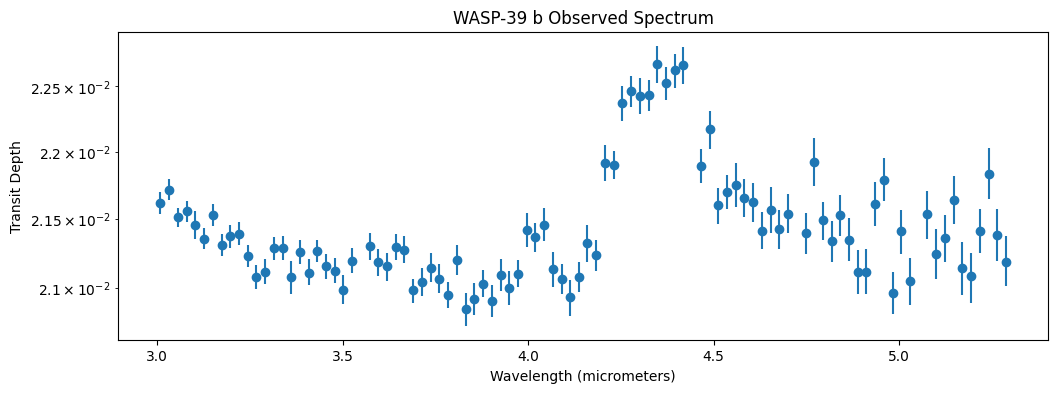

In [271]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.errorbar(observed_data['wavelength'], observed_data['tr_depth'], [observed_data['tr_depth_errneg'], observed_data['tr_depth_errpos']],fmt='o')
plt.title('WASP-39 b Observed Spectrum')
plt.yscale('log')
plt.ylabel('Transit Depth')
plt.xlabel('Wavelength (micrometers)')
plt.show()

Cool. This looks like the spectra we see in the news, but it doesn't look like the light curve above. That is because this data is split out by wavelength and then collapsed across time, as I'll explain. JWST measures the light curve at a bunch of different wavelengths, and the average dip in starlight across all those wavelengths is what we see in the light curve. If you split up a light curve into different wavelengths, you get something more like this:

<img src="https://drive.google.com/uc?id=17qgsvhXs4cGMsQHFKAWqS0_neL7mYbIe" width="1000px"></img> 

You can see that the "transit depth" is deeper for some wavelengths, where the planet's atmosphere is absorbing some more light than at other wavelengths (because molecules are transitioning states!). If we combine the data for each wavelength across the whole transit time - you can think of it as taking the average transit depth for the whole transit and comparing it to the “out of transit” baseline flux-, we instead get a spectrum like the one we've just plotted. Instead of the x axis being time, it is wavelength, and we get a measure of how much starlight was blocked by the planet at each wavelength. Looking at the data this way (collapsing the time axis) allows us to more easily pick out "features", or bumps in the graph that allude to the presence of certain molecules.

Bear with me for a tiny bit of easy maths here. It's important to know this because it is the fundamental measurement of transit spectroscopy, so you'll see it crop up everywhere. The Y axis on both the light curve and the spectrum is the "transit depth" or the "Amount of Light Blocked" of the star, like we discussed. This can be written as $\frac{\Delta F}{F}$, where F is the starlight only (Flux), ∆F is the change in starlight when it is blocked by the planet and the planet’s atmosphere. If the planet blocks 1% of the star's light, the $\frac{\Delta F}{F}$ would be 0.01. You can see on our plotted spectrum (or on the NASA image in the introduction) that WASP-39 b is blocking anywhere from 2.1% to 2.3% depending on wavelength.

This flux ratio is directly related to the ratio of the size of the planet versus the size of its host star, a quantity you'll often see as $\frac{\Delta F}{F}=\frac{R_p^2}{R_s^2}$ - the radius of the planet squared over the radius of the star squared, which makes sense if you think of it as the ratio between the area of two circles $(\pi r^2)$, with π canceled out. This means that if we know the radius of the host star, we get a handy way to compute the radius of an exoplanet by measuring the host star's light. [This tutorial](https://avanderburg.github.io/tutorial/tutorial2.html) by Andrew Vanderburg explains the concept really well. So when we look at spectra, we are equivalently looking at the amount of blocked light across different wavelengths, or the planet's apparent size across different wavelengths. That means that a spectrum can equivalently be showing $\frac{\Delta F}{F}$ or $\frac{R_p^2}{R_s^2}$, so don't be alarmed if you see different labels.

# 4. Spectra Ingredients

Great, now we understand what spectra are showing, how do we go about modeling synthetic exoplanets and creating our own?

This is where tools like PICASO come in- computing what a spectrum would look like for a given atmosphere on a particular planet, which is not a straightforward task to do from scratch. With PICASO we start small by setting physical properties like the planet's mass and radius. Then we can move on to more complex parameters like the temperature structure. In what follows we will step-by-step build up a planet's atmosphere using PICASO.

## Molecule Light Absorption Data

The first thing you need to know is information about each molecule's potential effect on a planet's spectrum. We know molecules absorb light at unique wavelengths. We gather that information through scientific experimentation. For example, in the lab we can directly measure the light absorbed  when passing light through pure gasses at a particular temperature and pressure. Some planets, like WASP-39 b are about a thousand degrees in temperature. When it becomes too difficult to reach certain temperatures in a laboratory, we can use what we know about quantum physics to theoretically predict the behavior instead.  Though we won’t cover that here it’s an important part of this work!

#### Line Lists / Opacities
When the scientific community computes, tests or updates the information we have about the behaviour of a certain molecule, they put it into "Molecular line lists", which are essentially huge databases storing the positions and intensities of the literal absorption lines you'd expect to see on a spectrum for a certain molecule's energy transitions. These line intensities are a function of temperature and wavelength. Changes in pressure "fuzz" the location of the lines, in an effect called pressure broadening, and result in something looking more like a smooth curve than many individual lines.

Astrophysicists use a version of this data processed (via a lot of hard work) into "opacity tables". An opacity table gives you the "cross section" of a molecule by wavelength, for a specific temperature and pressure. This is a measure of how much your molecule is able to absorb light (you can imagine that if a molecule has a bigger cross section, it is easier for light to hit it) at that wavelength. This also explains why they are called "opacities"- if your molecule has a large cross section and absorbs a lot of light at a wavelength, it is going to let less light through it, and will therefore be more "opaque". The 6GB file you downloaded at the start of this tutorial is one such opacity database. 

Let's load up the database and have a look.

In [272]:
db_filename = os.path.join(os.getenv('picaso_refdata'), 'opacities','opacities.db')

#### CO2

Let's see if we can load up CO2, because that was the exciting discovery on WASP-39 b. If we look at the [spectrum](https://www.nasa.gov/feature/goddard/2022/nasa-s-webb-detects-carbon-dioxide-in-exoplanet-atmosphere) we can see that there's a clear absorption band between 4 and 4.5 microns, so let's have a look at that region.

Let's start out with keeping our temperature constant and varying pressure:

In [273]:
species_to_get = ['CO2']
# We need to choose which temperature and pressure to use, because the absorption profiles of
# molecules change with changes in temp and pressure.
# We can google what the temperature is on WASP-39 b
t_to_get = [1100, 1100, 1100, 1100]#kelvin
# Let's get a range of pressures, so we can see how different the data is for the same
# temperature.
p_to_get = [1e-6, 1e-3, 1, 10] #in bars
data  = op.get_molecular(db_filename, species_to_get, t_to_get,p_to_get)

[(1, 1e-06, 75.0), (2, 3e-06, 75.0), (3, 1e-05, 75.0), (4, 3e-05, 75.0), (5, 0.0001, 75.0), (6, 0.0003, 75.0), (7, 0.001, 75.0), (8, 0.003, 75.0), (9, 0.01, 75.0), (10, 0.03, 75.0), (11, 0.1, 75.0), (12, 0.3, 75.0), (13, 1.0, 75.0), (14, 3.0, 75.0), (15, 10.0, 75.0), (16, 1e-06, 100.0), (17, 3e-06, 100.0), (18, 1e-05, 100.0), (19, 3e-05, 100.0), (20, 0.0001, 100.0), (21, 0.0003, 100.0), (22, 0.001, 100.0), (23, 0.003, 100.0), (24, 0.01, 100.0), (25, 0.03, 100.0), (26, 0.1, 100.0), (27, 0.3, 100.0), (28, 1.0, 100.0), (29, 3.0, 100.0), (30, 10.0, 100.0), (31, 30.0, 100.0), (32, 1e-06, 110.0), (33, 3e-06, 110.0), (34, 1e-05, 110.0), (35, 3e-05, 110.0), (36, 0.0001, 110.0), (37, 0.0003, 110.0), (38, 0.001, 110.0), (39, 0.003, 110.0), (40, 0.01, 110.0), (41, 0.03, 110.0), (42, 0.1, 110.0), (43, 0.3, 110.0), (44, 1.0, 110.0), (45, 3.0, 110.0), (46, 10.0, 110.0), (47, 30.0, 110.0), (48, 100.0, 110.0), (49, 1e-06, 120.0), (50, 3e-06, 120.0), (51, 1e-05, 120.0), (52, 3e-05, 120.0), (53, 0.0001,

In [274]:
x_1, y_1 = data['wavenumber'],data['CO2'][1100][0.000001]
x_2, y_2 = data['wavenumber'],data['CO2'][1100][0.001]
x_3, y_3 = data['wavenumber'],data['CO2'][1100][1.0] # Earth surface pressure.
x_4, y_4 = data['wavenumber'],data['CO2'][1100][10.0]

# Let's use an x_range similar to the nasa image we are looking at- 3 microns to 5.5 microns.
co2_fig = jpi.figure(height=300,y_axis_type='log',x_range=[3,5.5],y_range=[1e-26,8e-18]
                    , x_axis_label='Micron',y_axis_label='Cross Section (cm2/species)')


# We can convert wavenumber to wavelength in microns with 1e4/wavenumber
co2_fig.line(1e4/x_1, y_1,line_width=2, color='green', legend_label="0.000001")
co2_fig.line(1e4/x_2, y_2,line_width=2, color='blue', legend_label="0.001")
co2_fig.line(1e4/x_3, y_3,line_width=2, color='red', legend_label="1.0")
co2_fig.line(1e4/x_4, y_4,line_width=2, color='yellow', legend_label="10.0")
jpi.show(co2_fig)

It looks like there are some places where the pressure affects our absorption, notably the lower the pressure, the more “fuzzed” our absorption is into individual lines. We do see the tell-tale CO2 bump between 4 and 4.5 microns across the range of pressures though. We will discuss this later, but this is nice to know because we don't yet know what pressure the portions of WASP-39 b's atmosphere that we can absorb will be. 

Now let's keep our pressure the same and vary temperature:

In [275]:
# This time change our temperature
t_to_get = [500, 800, 1100, 2000]#kelvin
# Keep pressure consistent at something we would be likely to observe in an exoplanet atmosphere.
p_to_get = [1e-3, 1e-3, 1e-3, 1e-3] 
data  = op.get_molecular(db_filename, species_to_get, t_to_get,p_to_get)
x_1, y_1 = data['wavenumber'],data['CO2'][500][1e-3]
x_2, y_2 = data['wavenumber'],data['CO2'][800][1e-3]
x_3, y_3 = data['wavenumber'],data['CO2'][1100][1e-3]
x_4, y_4 = data['wavenumber'],data['CO2'][2000][1e-3]

# Make another plot.
co2_fig = jpi.figure(height=300,y_axis_type='log',x_range=[3,5.5],y_range=[1e-26,8e-18]
                    , x_axis_label='Micron',y_axis_label='Cross Section (cm2/species)')
co2_fig.line(1e4/x_1, y_1,line_width=2, color='green', legend_label="500k")
co2_fig.line(1e4/x_2, y_2,line_width=2, color='blue', legend_label="800k")
co2_fig.line(1e4/x_3, y_3,line_width=2, color='red', legend_label="1100k")
co2_fig.line(1e4/x_4, y_4,line_width=2, color='yellow', legend_label="2000k")
jpi.show(co2_fig)

[(1, 1e-06, 75.0), (2, 3e-06, 75.0), (3, 1e-05, 75.0), (4, 3e-05, 75.0), (5, 0.0001, 75.0), (6, 0.0003, 75.0), (7, 0.001, 75.0), (8, 0.003, 75.0), (9, 0.01, 75.0), (10, 0.03, 75.0), (11, 0.1, 75.0), (12, 0.3, 75.0), (13, 1.0, 75.0), (14, 3.0, 75.0), (15, 10.0, 75.0), (16, 1e-06, 100.0), (17, 3e-06, 100.0), (18, 1e-05, 100.0), (19, 3e-05, 100.0), (20, 0.0001, 100.0), (21, 0.0003, 100.0), (22, 0.001, 100.0), (23, 0.003, 100.0), (24, 0.01, 100.0), (25, 0.03, 100.0), (26, 0.1, 100.0), (27, 0.3, 100.0), (28, 1.0, 100.0), (29, 3.0, 100.0), (30, 10.0, 100.0), (31, 30.0, 100.0), (32, 1e-06, 110.0), (33, 3e-06, 110.0), (34, 1e-05, 110.0), (35, 3e-05, 110.0), (36, 0.0001, 110.0), (37, 0.0003, 110.0), (38, 0.001, 110.0), (39, 0.003, 110.0), (40, 0.01, 110.0), (41, 0.03, 110.0), (42, 0.1, 110.0), (43, 0.3, 110.0), (44, 1.0, 110.0), (45, 3.0, 110.0), (46, 10.0, 110.0), (47, 30.0, 110.0), (48, 100.0, 110.0), (49, 1e-06, 120.0), (50, 3e-06, 120.0), (51, 1e-05, 120.0), (52, 3e-05, 120.0), (53, 0.0001,

Cool! We can see that we still get our CO2 absorption features between 4 and 4.5 microns, though temperature does change absorption quite a bit - it looks like we get broader features with higher temperatures, so it is lucky we are dealing with a "hot Jupiter" if we are trying to spot CO2!

We could do this with any molecule we like in the database, and examine it under conditions (temp and pressure) that we expect on an exoplanet, to get a quick view on how the molecule behaves in isolation. PICASO will similarly use this database as an input, and it will adjust and combine the data for the different molecules on the planet it is modeling.

## Star Parameters

So now we can look up how molecules should behave under specific conditions, but in order to know what a spectrum from a planet would look like, we also need information about its host star. In order to perform transmission spectroscopy, we really only need the radius of the host star, but because PICASO also allows for other types of spectroscopy, we set it up with more data about the star.

We only need stellar radius because in transit spectroscopy we are measuring the relative area of the planet to the area of the star. As discussed above, we need to know this ratio by wavelength to produce the change in flux for our synthetic spectrum.

Let's get our information about WASP-39 b from [exo.MAST's page for the planet](https://exo.mast.stsci.edu/exomast_planet.html?planet=WASP39b).

We can get a list of the parameters we need for the PICASO functions in [the docs](https://natashabatalha.github.io/picaso/picaso.html). Ctrl-F for the <code>.star(</code> function which sets up the properties of the host star.

Some things of note for our parameters:

- We are using the default stellar database option, not the filename option. This uses the [pysynphot](https://pysynphot.readthedocs.io/en/latest/how_works.html) data set to simulate the stellar spectrum for the parameters you set up - it creates synthetic photometry (read: starlight) to pass through our model exoplanet's atmosphere.

- The <code>metal</code> parameter is 'metallicity' which is given as [Fe/H] in exo.MAST as it is a measure of the ratio of heavier elements (Fe) to lighter elements (H) in the star (the units are in relation to the metallicity of our sun - so a value close to 0 like this one means a similar metallicity to our sun. We are going to dive into this parameter more deeply on our exoplanet for the "Chemistry Parameters'' section below.

- The <code>logg</code> option is the gravity of the star in log base 10, and in cgs units. CGS units are centimeter–gram–second, and logg is "Log g" - log gravity. This is labeled as log<sub>10</sub>(g)[cgs] in exo.MAST, and if you hover over it you can see it says "stellar surface gravity".

In [276]:
import astropy.units as u
import pandas as pd

# Open a connection to the database we read from in the previous section, 
# so that PICASO can use it as it wishes, but clip the range of wavelengths 
# to load up so it runs faster.
opacity = jdi.opannection(wave_range=[1,5])

# the .inputs() function instantiates a blank PICASO model
synthetic_wasp39b = jdi.inputs()

# For transmission spectroscopy we only need to specify temp, metal, logg, radius, and radius unit, 
# but there are other options you can set in the star() function.
# These values are directly taken from exo.MAST's WASP 39 b page.
synthetic_wasp39b.star(opacity, temp=5400 , metal=0.01, logg=4.45, radius=0.9, radius_unit=u.Unit('R_sun') )

## Planet Parameters
We also need to give PICASO information that we know about the planet itself. 

### Gravity
Gravity is important because it governs an important property of the planet’s atmosphere- “scale height”. This is a measure of how much an atmosphere “hugs” a planet, or how compressed or extended it is. It tells us how the pressure scales in the planet’s atmosphere with altitude. Mathematically, it is  the vertical distance over which the density and pressure fall by a factor of 1/$e$. The scale height sets the size of the features (bumps) we will see in the spectrum. Remember that these bumps reflect changes in the apparent size of the planet at different wavelengths. If the atmosphere extends many kilometers beyond its surface then the difference in the apparent size of the planet has the potential to be much larger.

Here we want to Ctrl-F in [the docs](https://natashabatalha.github.io/picaso/picaso.html) for the <code>.gravity(</code> function, which informs PICASO about the gravity on the planet.

In [277]:
# PICASO really needs information about the gravity on a planet, which we can specify
# by telling it the mass and (average across wavelengths) radius of the planet.

# We get these values from exo.MAST, which conveniently has them in the units we are used to!
synthetic_wasp39b.gravity(mass=0.28, mass_unit=u.Unit('M_jup'), radius=1.27, radius_unit=u.Unit('R_jup'))

### Pressure / Temperature Atmosphere Profile

PICASO also needs to know what kind of atmosphere you want to model. The most important component of this is thePressure-Temperature (P-T) profile. This just means stating how temperature varies as you go from the outer reaches of the atmosphere (low pressure) to deep within the planet's atmosphere (high pressure). Generally, the temperature is cool in the upper atmosphere and gets hotter as the pressure increases towards the surface of the planet.

For the purposes of learning, we can start with setting up a very simple Temperature-Pressure profile where temp remains constant throughout the atmosphere. We do this by giving PICASO a list of pressure values and their corresponding temperature values, where each entry of the list is called a "level"- mapping to an altitude "level" in the planet's atmosphere with that pressure. If you use more levels your model will be more detailed but run slower. 50-90 is recommended.

#### Pressure
If we imagine our "levels" as equally spaced altitude bands on the planet, then we will assign pressures to each that decrease logarithmically with increased altitude, because gas is compressible and tends to behave in that way in planetary atmospheres (including earth).

In [278]:
nlevels = 50
# Logspace goes from base^(start) to base^(end)
# so here we are going from 10^-6 to 10^2, which is
# 1 microbar to 100 bars of pressure.
pressure = np.logspace(-6,2,nlevels)

#### Temperature

For our corresponding temperature values, we are going to start out with keeping temperature constant as we increase levels, which is called "isothermal". This is a big simplification but is something we can compare to when we get more sophisticated.

In [279]:
# We can see from exo.MAST that the equilibrium temp
# of WASP 39 b is 1120 kelvin, so let's use a scale
# around that of temperatures.
isothermal_temperature = np.full(pressure.shape, 1120.55)

#### Fancier Temperature

If we want to be a bit fancier than our very simple P-T profile we set up above, we can use an analytical equation that more closely approximates a “real” P-T profile in an atmosphere. The equation uses a variable $\gamma$ ("gamma") to govern what we want the profile to look like.

A positive $\gamma$ creates a profile where temperature increases with pressure (called "greenhouse"), whereas a $\gamma$ of 1 creates a profile that stays the same temperature regardless of pressure (like the isothermal toy one we just set up manually). A $\gamma$ close to 0 creates an "inverted" atmosphere where the temperature decreases with increased pressure. This sounds weird but sometimes this does happen when molecules trap enough energy high up in the atmosphere (like ozone in earth's own atmosphere!).

If you want, you can read more about this 'double gray model' in the paper [here by Guillot et al. 2010](https://arxiv.org/pdf/1006.4702.pdf), but you are welcome to just trust me that the following code produces sensible temperature/pressure profiles for us to use.

Let's explore $\gamma$ = 0.1, and $\gamma$ = 10 to see what it gives us, and we can use our existing isothermal temperature for $\gamma$ = 1

The value $\tau$ ("tau") is a measure of "optical depth" which basically tells us how opaque a material is. Here we are saying that as our atmosphere gets denser (higher pressure) we are going to increase our optical depth logarithmically- it is going to get harder for light to pass through, but not linearly harder as we increase pressure. You can read more about optical depth (I started [here](http://spiff.rit.edu/classes/phys440/lectures/optd/optd.html) and [here](http://astro.vaporia.com/start/opticaldepth.html)) if you want to know why that is a sensible choice to make.

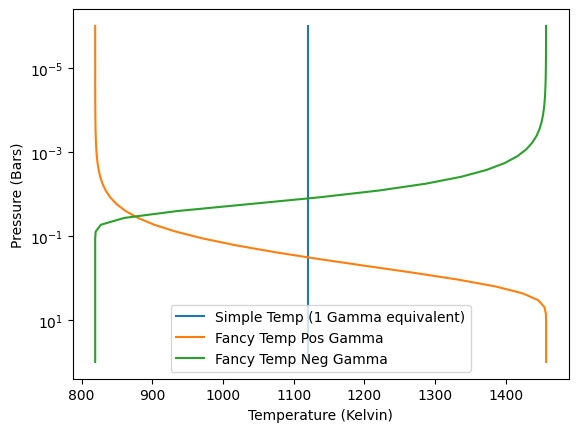

In [280]:
# A scaling factor we can mess around with representing how much of the 
# star's rays get to the planet
F_sig = 800**4
# Let's assume the optical depth logarithmically increases from 1e-5-1000
tau =np.logspace(-5,3,50)

# The fancy equation from the double gray model to get our list of temperatures 
# to match our list of pressures.

# Pick gamma to give us a greenhouse style atmosphere
gamma = 10
pos_gamma_temperature = (F_sig * ((1/gamma -gamma)*np.exp(-tau/gamma) +1 + gamma)) **(0.25)

# Pick gamma to give us an inverted greenhouse style atmosphere
gamma = 0.1
neg_gamma_temperature = (F_sig * ((1/gamma -gamma)*np.exp(-tau/gamma) +1 + gamma)) **(0.25)


## Let's sanity check what we have done.
plt.plot(isothermal_temperature, pressure, label='Simple Temp (1 Gamma equivalent)')
plt.plot(pos_gamma_temperature, pressure, label='Fancy Temp Pos Gamma')
plt.plot(neg_gamma_temperature, pressure, label='Fancy Temp Neg Gamma')
plt.legend()
plt.yscale('log')
plt.ylabel('Pressure (Bars)')
plt.xlabel('Temperature (Kelvin)')
plt.gca().invert_yaxis()

plt.show()

#### Setting the Atmosphere in PICASO

Now we have three options for temperature, `isothermal_temperature`, `pos_gamma_temperature` and `neg_gamma_temperature`. Let's use isothermal and greenhouse (ignoring the less intuitive inverted version) and make two versions of our model. We can store both and compute their spectra later to compare.

In [281]:
# Make a dictionary to hold our models.
import copy
planets = {}
planets['isothermal'] = copy.deepcopy(synthetic_wasp39b)
planets['greenhouse'] = copy.deepcopy(synthetic_wasp39b)


# Now let's add our parameterized profiles
planets['isothermal'].atmosphere(df = pd.DataFrame({
                'pressure':pressure,
                'temperature':isothermal_temperature}),verbose=False)

planets['greenhouse'].atmosphere(df = pd.DataFrame({
                'pressure':pressure,
                'temperature':pos_gamma_temperature}),verbose=False)



### Chemistry Parameters

Our final important component is the chemistry of the planet's atmosphere- that is, which molecules are actually present. If we knew exactly which ones were there, and how much of each there were, we could force PICASO to use those directly.

Unfortunately, since we aren't astrophyscists, we have no idea what molecules would be present (and the astrophysicists don’t have much more of an idea than us!). Worse, we (probably) aren't chemists either, so if we were to totally guess the molecules and their relative abundances, we'd probably pick a mixture that wouldn't even work in the physical world (our molecules would probably react with each other and not be a stable mixture).

Luckily PICASO can help us here. If we give PICASO two important parameters to work off - Metallicity and C/O ratio, it can find a mixture of molecules that would be in a stable equilibrium on the exoplanet. It does this by using an external chemistry database that was computed by a Chemistry professor called [Channon Visscher](https://www.spacescience.org/bio.php?emp=CVISSCHER). 

#### Metallicity

<img src="https://drive.google.com/uc?id=1XPOsOCrfzQhCzxV0NloZ_n1lZbalmV0s" width="400">

Metallicity is a measure of how many "heavier" elements are present. In astronomy "metals" are any elements heavier than hydrogen and helium, and so "metallicity" is the ratio of metals to nonmetals. It can be written as M/H (Metals to Hydrogen), and for stars, which can be relied upon to have iron in them, it is often also measured more specifically by Fe/H (Iron to Hydrogen) - which you may have seen earlier in exo.MAST when we looked up the metallicity of the host star for our .star() inputs. Iron is partly used because it is easy to detect in spectroscopy. For our purposes we will stick to M/H since planets might not have iron, and the two measurements can be thought of as interchangeable.
Also of note is that planet metallicity is measured relative to solar metallicity of our sun. So we will input log_mh as our metallicity- the natural log of the planet's metallicity relative to the sun's metallicity. In other words ([Wikipedia's words](https://en.wikipedia.org/wiki/Metallicity#Chemical_abundance_ratios)), stars and planets with a higher metallicity than the Sun have a positive common logarithm, whereas those more dominated by hydrogen have a corresponding negative value. For example, a planet with a metallicity value of +1 has 10 times the metallicity of the Sun; conversely, a value of −1 will have 1⁄10, while one with a value of 0 will have the same metallicity as the Sun.

If we know the metallicity of a planet's host star, that tells us what the metallicity of the disk of material that formed from the formation of the star approximately was. A star’s planets are then born from this disk, so it governs the material available for their formation. From looking at our own solar system we see that: 
   1) There is a similarity between the metallicity of our sun and that of the gas giants in the solar system (as they formed from the same disk of material) 
   2) [There is a trend of decreasing metallicity with increased mass of the gas-giant planets](https://stellarplanet.org/science/mass-metallicity/). We haven’t yet proven this to be true for exoplanets, but we have proven a relationship between increased metallicity of a star and the likelihood of it having planets at all.

If we take a guess and follow what we see from our own solar system, knowing the metallicity of WASP-39 b's star, and the planet's size, we can predict the metallicity of the planet's atmosphere. WASP-39 b's host star has a metallicity very similar to our own Sun (we saw this above in the "Star Parameters" section) and WASP-39 b has a mass similar to that of Saturn, and therefore we can predict it has a similar metallicity of __~ 10x solar__.

Interestingly, data we had from before JWST's observation- from HST, a predecessor telescope- didn't necessarily align with this 10x solar prediction. Measuring planet metallicity directly can be tricky, and HST could only measure H2O absorption and so we had to use H2O abundance as a proxy for metallicity. However, the H2O we observed in WASP-39 b's atmosphere implied a much higher metallicity: >100x solar.

The JWST detection of CO2 was especially exciting because of its expanded wavelength coverage and resolution. Access to more molecules (like CO2) resulted in a more “sensible” metallicity of 10x inline with what we see in our own solar system. The new information allowed us to explain the previous H2O findings via the presence of clouds (which affect things in complicated ways, as we will discuss later in this tutorial).

Let's set our metallicity to 10x solar, which will help PICASO constrain what molecules will be present (ex: it will know not to make hydrogen and helium more abundant than they are in our sun):

In [282]:
log_mh = 1.0 #log relative to solar, so 10^1 here = 10x solar.

#### C/O Ratio

Another important chemical ratio is that of Carbon to Oxygen in a planet's atmosphere. This is a little less straightforward than metallicity, but is exciting to astronomers because it could give us information about where in the disk a planet formed.

At a high level, this number could tell us how far from the parent star the planet initially formed (though planets can migrate in their lifetimes). This is because, in the primordial disk of material that planets form from, molecules will be available in either gas or solid form depending on their freezing point and on how far from the center, and therefore colder, the planet forms. For us, this number is important because it tells us the concentrations of molecules with Oxygen in them (example: H2O) vs molecules with Carbon in them (eg: CO, CO2, CH4).

A planet with a fixed P-T profile and fixed metallicity could still have a big variance of molecule abundances depending on its C/O ratio. This effect is more extreme for hot planets like WASP-39 b, for example you can see here that for a temperature of 2000 kelvin, varying C/O can take you from an atmosphere dominated by water to one where water isn't even in the top 5 most abundant molecules:

_From the paper [C/O RATIO AS A DIMENSION FOR CHARACTERIZING EXOPLANETARY ATMOSPHERES](https://iopscience.iop.org/article/10.1088/0004-637X/758/1/36)_

<img src="https://drive.google.com/uc?id=1tNdEkaikY7MpL3hETomOW2S0AmfE8ba6" width="500"></img>

C/O is also given in PICASO in units relative to solar C/O, which is worth noting because you're not giving it the actual ratio of Carbon to Oxygen, but rather the ratio relative to the Solar C/O, which is ~0.5.

In [283]:
# Let's cheat a bit, and use the fact that we know CO2 was observed on 
# WASP-39 b to keep our C/O low, as we can see in the graph above that above
# a C/O of 1, CO2 drops right off.

c_o = 0.23 #relative to solar

Now we can ask PICASO to make us a mixture of molecules consistent with the Metallicity and CO we set up, and we can take a look at what it creates. We can look at the "atmosphere profile" which shows us the abundances of various molecules at different levels of our atmosphere (levels being places where temperature and pressure differ in the manner we defined above).

In [284]:
for i in planets:
    # Tell PICASO to use the Channon Visscher database to find chemistry consistent with our C/O and M/H
    planets[i].chemeq_visscher(c_o, log_mh)
    
# Look at the very top levels of our planet's atmosphere
planets['isothermal'].inputs['atmosphere']['profile'].head()

pressure  temperature            e-        H2         H            H+  \
0  0.000001      1120.55  9.498356e-10  0.828774  0.000037  4.505256e-38   
1  0.000001      1120.55  7.796277e-10  0.828775  0.000031  4.505298e-38   
2  0.000002      1120.55  6.399206e-10  0.828776  0.000025  4.505340e-38   
3  0.000003      1120.55  5.252200e-10  0.828777  0.000021  4.505378e-38   
4  0.000004      1120.55  4.308026e-10  0.828778  0.000017  4.505378e-38   

             H-           H2-           H2+           H3+  ...            Cs  \
0  1.538724e-18  8.817604e-28  4.505256e-38  4.505256e-38  ...  1.252502e-10   
1  1.524248e-18  1.054155e-27  4.505298e-38  4.505298e-38  ...  1.191536e-10   
2  1.509909e-18  1.260255e-27  4.505340e-38  4.505340e-38  ...  1.133538e-10   
3  1.495612e-18  1.506544e-27  4.505378e-38  4.505378e-38  ...  1.078394e-10   
4  1.480374e-18  1.799484e-27  4.505378e-38  4.505378e-38  ...  1.026284e-10   

        CO2           HCN          C2H2          C2H4          C2H6  \
0  0.000009  5.172500e-15  1.499602e-24  5.773257e-29  2.037543e-35   
1  0.000009  7.534022e-15  3.181455e-24  1.783949e-28  9.170084e-35   
2  0.000009  1.097370e-14  6.749561e-24  5.512443e-28  4.127051e-34   
3  0.000009  1.598356e-14  1.431897e-23  1.703279e-27  1.857292e-33   
4  0.000009  2.327666e-14  3.036619e-23  5.260091e-27  8.352426e-33   

            SiO           MgH           OCS      graphite  
0  3.557492e-08  9.976143e-17  1.207203e-08  4.500000e-38  
1  2.442593e-08  8.266581e-17  1.278553e-08  4.500000e-38  
2  1.677098e-08  6.849978e-17  1.354120e-08  4.500000e-38  
3  1.151518e-08  5.676162e-17  1.430968e-08  4.500000e-38  
4  7.907648e-09  4.703792e-17  1.473160e-08  4.500000e-38  

[5 rows x 36 columns]

You can see that PICASO has given us loads of different molecules to work with, but many have miniscule abundances (note some e-38 values in there). We will unpack this chemistry later in the tutorial, but for now we can stick with this black-box equilibrium setup.

### Reference Pressure

Lastly, we need to decide on a "reference pressure". If our planet was terrestrial, this would be the pressure at the surface, and therefore also the pressure corresponding to the radius of the planet. For gas giants like WASP-39 b this is a bit more complicated- there is no "surface", so we need to pick a pressure that corresponds to our planet's "radius", so that PICASO can calculate gravity as a function of altitude from that level.

As we've discussed, a planet's radius changes depending on the wavelength at which you observe it- it's that change that we are measuring with our spectra. But when we input the planet radius above, we picked a single number- 1.27 `r_jup`. That number is an average calculated over a band of wavelengths, and so when we pick a reference pressure, we estimate roughly what level of the planet's atmosphere that averaged radius corresponds to (where, from the high pressure deep inside, to the low pressure at the exterior, does the chosen radius fall?).

PICASO suggests a reference pressure of 10 bar for gas giants, so we will start with that:

In [285]:
for i in planets:
    planets[i].approx(p_reference=10)

# 5. Simulation Time!

Now we have set up PICASO with everything it needs, and we understand the components needed to model an exoplanet, let's ask PICASO to output a transmission spectrum for our WASP-39 b.

## Run PICASO

We can use the <code>.spectrum</code> function to do so. 

We need to give the function a connection to the opacity database we used earlier to look up the absorption spectrum for water, as well as an instruction to create a "transmission" spectrum (as opposed to, for example, a reflected light spectrum of star light bouncing off the planet when it's almost behind its star).

In [286]:
models = {}
for i in planets:
    models[i] = planets[i].spectrum(opacity, calculation='transmission',full_output=True)

# We are interested in 'transit_depth' per 'wavenumber', explained below. 
print('Output from spectrum function: ', models['isothermal'].keys())
# Don't worry about warnings if they seem to be ignoring molecules that aren't real, or that you
# don't care about.

/Users/kappi/miniconda3/lib/python3.9/site-packages/picaso/atmsetup.py:190: UserWarning: Ignoring graphite in input file, not a recognized molecule
  warnings.warn("Ignoring %s in input file, not a recognized molecule" % i, UserWarning)
/Users/kappi/miniconda3/lib/python3.9/site-packages/picaso/atmsetup.py:190: UserWarning: Ignoring graphite in input file, not a recognized molecule
  warnings.warn("Ignoring %s in input file, not a recognized molecule" % i, UserWarning)


Output from spectrum function:  dict_keys(['wavenumber', 'transit_depth', 'full_output'])


## Our Spectra!

Let's set up a function to display all the spectra in our `planets` dictionary, so we can easily add more and compare them.

In [287]:
def show_spectra(outputs, x_range_min=3.0, x_range_max=5.5):
    # Downsample the output so the graph is smooth enough to make sense of.
    # Wavenumber is analogous to wavelength, and we know transit depth is the amount of light blocked by the planet.
    wnos, rprs2s = zip(*[jdi.mean_regrid(outputs[x]['wavenumber'], outputs[x]['transit_depth'], R=150) for x in outputs])
    rprs2s = [x*1e6 for x in rprs2s]
    wnos = [x for x in wnos]

    # Plot our synthetic spectrum.
    fig = jpi.spectrum(wnos, rprs2s, legend=[x for x in outputs], plot_width=800,
                       y_axis_type="log", x_range=(x_range_min,x_range_max))

    # Plot the observed spectrum as well, to see how it matches up.
    jpi.plot_multierror(observed_data['wavelength'], observed_data['tr_depth']*1e6, fig, 
                        dy_low=observed_data['tr_depth_errneg']*1e6, dy_up=observed_data['tr_depth_errpos']*1e6
                        , dx_low=[0],dx_up=[0], point_kwargs={'color':'red'})
    jpi.show(fig)

In [288]:
# Display our first spectra!
show_spectra(models)

Sweet! We have spectra that look the right-ish shape, even though they aren't quite in the right place. Let's take a minute to work that out.

### Y-Axis Offsets

We can see that our two spectra seem to be saying WASP-39 b is blocking more light than it actually did (the real data plotted below). That sounds like maybe the radius we gave to picaso was too big, and the planet is in fact smaller. Let's add another model with a smaller radius.

But, you might say, that is the radius, exo.MAST said so, and who are we to argue with it? Well, firstly we know that radius changes depending on the wavelength with which we observe the planet, and so having a singular radius measurement doesn't really make sense. The "official" measurement we see on exo.MAST is an average across all the wavelengths observed by the study that determined the radius- which may not be the same band we are using. In fact, many [exoplanet finding missions](https://exoplanets.nasa.gov/discovery/missions/#first-planetary-disk-observed) (TESS, Kepler) observed in the visible portion of the spectrum, which is shorter wavelengths than the JWST observations we are looking at - so many of the radius measurements we have are an average of the radius as seen over a range entirely <1 micron.

On the other hand, the radius we are using in PICASO corresponds to a specific pressure in the planet's atmosphere- the `reference pressure` we set earlier at 10 bars. So, we want to tell PICASO what the radius of the planet is where the atmospheric pressure is 10 bars, which might not be the same radius we observe through telescopes. This is because the planet might become "optically thick" or "opaque" at lower pressures higher up in the atmosphere, and so the radius we measure via observation probably corresponds to a higher altitude where the pressure is much less than 10 bars. For example, if you imagine measuring the radius of the earth from space on a magical day where there were no clouds anywhere, you'd get a radius corresponding to the surface of the earth (at a pressure of 1 bar), but if you imagine measuring the earth on a (magical again) day where the whole earth is covered in clouds, you'd get a slightly bigger radius (the top of the clouds) corresponding to a lower pressure higher in the atmosphere.

This is all to say, it's ok if we decrease the radius of WASP-39 b a bit to get the spectrum to line up with the observation, as long as it is within "sensible" limits. For us, we can adjust our radius to 1.16 or 1.18 `r_jup` to get it to fit the isothermal and greenhouse models respectively- a change of ~9%, which feels like a reasonable amount to shrink to match 10 bar on average across the spectrum.

In [289]:
# Make 2 more models with and adjusted radius
planets['small_radius_greenhouse'] = copy.deepcopy(planets['greenhouse'])
planets['small_radius_greenhouse'].gravity(mass=0.28, mass_unit=u.Unit('M_jup'), radius=1.18, radius_unit=u.Unit('R_jup'))

planets['small_radius_isothermal'] = copy.deepcopy(planets['isothermal'])
planets['small_radius_isothermal'].gravity(mass=0.28, mass_unit=u.Unit('M_jup'), radius=1.16, radius_unit=u.Unit('R_jup'))

models = {}
for i in planets:
    models[i] = planets[i].spectrum(opacity, calculation='transmission',full_output=True)
show_spectra(models)

/Users/kappi/miniconda3/lib/python3.9/site-packages/picaso/atmsetup.py:190: UserWarning: Ignoring graphite in input file, not a recognized molecule
  warnings.warn("Ignoring %s in input file, not a recognized molecule" % i, UserWarning)
/Users/kappi/miniconda3/lib/python3.9/site-packages/picaso/atmsetup.py:190: UserWarning: Ignoring graphite in input file, not a recognized molecule
  warnings.warn("Ignoring %s in input file, not a recognized molecule" % i, UserWarning)
/Users/kappi/miniconda3/lib/python3.9/site-packages/picaso/atmsetup.py:190: UserWarning: Ignoring graphite in input file, not a recognized molecule
  warnings.warn("Ignoring %s in input file, not a recognized molecule" % i, UserWarning)
/Users/kappi/miniconda3/lib/python3.9/site-packages/picaso/atmsetup.py:190: UserWarning: Ignoring graphite in input file, not a recognized molecule
  warnings.warn("Ignoring %s in input file, not a recognized molecule" % i, UserWarning)


Fantastic, now we are talking. Let's just go ahead and use these updated radii as our default models.

In [290]:
planets.pop('small_radius_greenhouse')
planets.pop('small_radius_isothermal')

# Set our original models to smaller radii
planets['greenhouse'].gravity(mass=0.28, mass_unit=u.Unit('M_jup'), radius=1.18, radius_unit=u.Unit('R_jup'))
planets['isothermal'].gravity(mass=0.28, mass_unit=u.Unit('M_jup'), radius=1.16, radius_unit=u.Unit('R_jup'))
    
models = {}
for i in planets:
    models[i] = planets[i].spectrum(opacity, calculation='transmission',full_output=True)
show_spectra(models)

/Users/kappi/miniconda3/lib/python3.9/site-packages/picaso/atmsetup.py:190: UserWarning: Ignoring graphite in input file, not a recognized molecule
  warnings.warn("Ignoring %s in input file, not a recognized molecule" % i, UserWarning)
/Users/kappi/miniconda3/lib/python3.9/site-packages/picaso/atmsetup.py:190: UserWarning: Ignoring graphite in input file, not a recognized molecule
  warnings.warn("Ignoring %s in input file, not a recognized molecule" % i, UserWarning)


Sweet!! That looks pretty good! We have definitely matched the telltale CO2 bump, and we don't need to feel too bad about not matching the smaller bump at 4 microns, because the scientists who published [the paper](https://arxiv.org/pdf/2208.11692.pdf) whose observation data we are using still call it a "mystery feature". Because they were aiming to show the presence of CO2, they didn't worry about perfectly matching the data, but they are working on that now and so if you want to have a go adjusting spectra components and beat them to it, go ahead!

## Measuring Error

Before we go on, we need a more rigorous way of measuring how well our synthetic spectra fit the observed data. Some adjustments will make it ambiguous to determine which option is better, so we can instead implement a measurement of error called "chi squared". This is a commonly used method to measure how well you are fitting data with a model, and basically sums up the distance between your output and the observed data at each data point. If you exactly matched the data, it would be a sum of all zeroes, but this likely means your model is “overfitting” your data- and that new data points likely wouldn’t fit your model. So you are looking to get closest to 1, which is a good (but not too good) fit.

Don't be alarmed by the maths, you can see in this example how chi_sqaured works, imagine our `greenhouse` and `isothermal` spectra were the straight blue and red lines:

<img src="https://drive.google.com/uc?id=1IZVQmKv5HVeL45m3KpN4-rseApbvjGNG" width="800">

You can see in the function below that we are taking the difference between the transit depth of our model and the observed transit depth at the same wavelength, dividing by the error on the observed data (to allow our model wiggle room inside the observation's error margin), and then squaring it and summing across all the observed wavelengths. Finally we divide by the number of observed wavelengths to get an average error across our data (they don't do this last bit in the image above).

In [291]:
def chisqr(observed, model, error):
    return np.sum(((observed-model)/error)**2 ) / len(observed)

The formula above assumes you have two arrays of the same length, representing the transit depth corresponding to the same set of wavelengths. Our data doesn't look like that- we have fewer observed points than our model has output. So, let's use some numpy magic to find the average value for wavelength bins in our model's output that most closely correspond to the observed wavelengths, and then extract the transit depth our model output at those wavelengths.

In [292]:
def getCorrespondingDatapoints(observed, modeled):
    # Extract the wavelengths from the observed data and put it in numpy format
    observed_wavelengths = np.array(observed['wavelength'])
    # Get the data on the same units as our model and flip so it is ascending
    observed_wavenumber = 1e4/observed_wavelengths[::-1]
    # Bin the model to the data (note new_model_wno is now the same as observed_wavenumber)
    new_model_wno, model_tr_depth = jdi.mean_regrid(modeled['wavenumber'],
                                                    modeled['transit_depth'],
                                                    newx=observed_wavenumber)
    # Flip again to match data
    model_tr_depth = model_tr_depth[::-1]
    # Find any indices where we don't have model data that matches the observed.
    non_nan_indices = np.logical_not(np.isnan(model_tr_depth))
    
    return(model_tr_depth, non_nan_indices)

Cool, now we are ready to get the error on our models.

In [293]:
def printChiSqr(models):
    observed_tr_depth = observed_data['tr_depth']
    # Get the errors for the observed datapoints.
    error = (observed_data['tr_depth_errneg'] + observed_data['tr_depth_errpos'])/2
    
    # Get the subset of our output corresponding to the observed data
    for i in models:
        (model_tr_depth, non_nan_indices) = getCorrespondingDatapoints(observed_data, models[i])
        print(i, ' chisqr: ', 
              chisqr(observed_tr_depth[non_nan_indices], model_tr_depth[non_nan_indices], error[non_nan_indices]))

printChiSqr(models)

isothermal  chisqr:  7.659766331836259
greenhouse  chisqr:  3.0627891835887864


Sweet, as we could probably tell by eyeballing the graph, our greenhouse model is closer to the observed data. Let's get rid of our isothermal one and just work with our greenhouse one from now on:

In [294]:
planets.pop('isothermal')
print(planets.keys())
models = {}
for i in planets:
    models[i] = planets[i].spectrum(opacity, calculation='transmission',full_output=True)

dict_keys(['greenhouse'])


/Users/kappi/miniconda3/lib/python3.9/site-packages/picaso/atmsetup.py:190: UserWarning: Ignoring graphite in input file, not a recognized molecule
  warnings.warn("Ignoring %s in input file, not a recognized molecule" % i, UserWarning)


## So, what are we looking at?
We have a spectrum, and we have a way to measure how "good" of a fit it is for our observed data, but let's look at a couple of rich pieces of data PICASO also gives us in its output. These pop up often in the exoplanet fields so it's very worth taking the time to understand them.

#### Pressure-Temperature Profile
First let's plot the pressure-temperature profile of the atmosphere. This is a warm up because we did this before we added the P-T profiles to PICASO, but let's confirm it understood. You can think of these graphs as "cross sections" of the planet's atmosphere, with the high pressures at the bottom - closer to the center of the planet.

In [295]:
for i in models:
    full_output = models[i]['full_output']
    # the .pt() function is specifically for pressure/temperature
    # plots and defaults to a log scale on the Y axis, and adds
    # the right axis labels.
    print('P-T Profile for', i)
    jpi.show(jpi.pt(full_output,plot_width=500))

P-T Profile for greenhouse


Great, just as we expected, PICASO used the fancier greenhouse temperature profile we expected for our greenhouse model. Note where 10 bar is on the graph- pretty near the bottom (or "deep" into the planet), which lines up with how we constricted the radius of the planet earlier to match 10 bar.

#### Mixing Ratios

Next, we are going to look at something a little more complex, called "mixing ratios". This is a graph with the same setup, where high pressure is at the bottom. It is going to show us the fraction (all abundances add up to 1 at each level) of the different chemicals in the atmosphere at different pressures.

We will limit the function to the top few molecules for simplicity. Can you spot CO2??

In [296]:
for i in models:
    print('Mixing Ratio for', i)
    jpi.show(jpi.mixing_ratio(models[i]['full_output'],limit=10,plot_width=500))

Mixing Ratio for greenhouse


Note that CO2 is the ~7th most abundant molecule high up in the atmosphere, but lower down at higher pressures it's right down as the 10th. This is important to recognize because it has implications for what molecules we can detect on a planet.

Remember the  "tau" variable for "optical depth" we talked about in the "Fancier Temperature" section? Well it turns out that is a very important concept in astrobiology, because it varies by molecule and wavelength, which means that at a certain pressure and wavelength, some molecules may be opaque while others are transparent. So, let’s say you have a molecule of interest that is only abundant at high pressures, but there is a different molecule that "becomes opaque" at a lower pressure than where your molecule of interest becomes abundant. Ultimately, you won't be able to "see" deep enough into the planet to realise that molecule is present! 

That is why it's important to look at these various breakdowns of data, so that you can understand the limits of what you're seeing. You often see this referred to as "what pressures your spectrum is sensitive to", which is another way of asking how deep into the planet's atmosphere you can see, unlocking the possibility of understanding what molecules may live deeper inside.

#### Contributions

Our last diagnostic plot is used to exactly diagnose what I described above, and this one is also very important, and also the most complicated (but don't worry, not horribly!). A "contribution" plot is used to see where the "=1" surface is for the different molecules in the atmosphere. This just means it tells you at what pressure each molecule becomes "opaque", at each wavelength.

This is very useful, because at a glance we can see what molecules we have a hope of seeing show up in our spectrum. Say that a molecule should cause a spike in a spectrum, and it is present on our planet. If there's some other molecule present with a =1 surface at much lower pressures in the wavelength where we hope to see our spike, we won't be able to see it, because the interfering molecule will make the planet opaque at a higher altitude and we won't be able to see deep enough into the atmosphere to see our molecule of interest.

Let's take a look at our contribution plot below:

In [297]:
def plotContribution(planets):
    for i in planets:   
        contribution = jdi.get_contribution(planets[i], opacity, at_tau=1)

        wno=[]
        spec=[]
        labels=[]
        for j in contribution['tau_p_surface'].keys():
            x,y = jdi.mean_regrid(opacity.wno, contribution['tau_p_surface'][j],R=100)
            if np.min(y)<5: # Bars
                wno+=[x]
                spec+=[y]
                labels +=[j]
        fig = jpi.spectrum(wno,spec,plot_width=600,plot_height=350,
                           y_axis_label='Tau~1 Pressure (bars)',
                           y_axis_type='log',x_range=[1,5],
                             y_range=[1e2,1e-4],legend=labels)
        print("Contribution plot for", i)
        jpi.show(fig)
plotContribution(planets)

/Users/kappi/miniconda3/lib/python3.9/site-packages/picaso/atmsetup.py:190: UserWarning: Ignoring graphite in input file, not a recognized molecule
  warnings.warn("Ignoring %s in input file, not a recognized molecule" % i, UserWarning)


Contribution plot for greenhouse


Even though this is a busier plot, we can see straight away that H2O and methane (CH4) have a $\tau$=1 surface that is high above the other molecules until >4 microns. That's when we see CO2 pop up, which makes sense because that is the wavelength region studied in the paper that confirmed CO2. 

If we only had a telescope capable of seeing 2-3.5 microns, we wouldn't be able to confirm CO2 because other molecules would obscure it.

It's worth noting that sometimes, there will be "windows" in the $\tau$=1 surface of a molecule, where the line dips and you can "see" further into high pressure zones. Those wavelength regions can be particularly interesting to glimpse deeper into the planet's atmosphere. For example, at ~1 microns, we can "see" all the way to 1 bar of pressure.

#### Shorter Wavelengths

We only have observed JWST data from 3-5.25 microns, but PICASO outputs a wider range. Let's have a look at our whole spectrum and see what it implies.

In [298]:
# Plot our whole spectrum
show_spectra(models, 1.0, 5.5)

What do you notice here? Can you compare this to the contribution plot section and take a guess at which molecules PICASO thinks will show up in the spectrum between 1 and 3 microns? I can certainly see three features that seem to line up with the H2O contribution.

It is interesting to note here that the contribution plots are not a direct explanation of what you see in the spectra- for example the contribution plot seems to imply methane would produce a more obvious bump. There is a little spike at ~3.3 microns like methane has, but overall the spectrum is flatter than you'd get from tracing the tops of the contribution plots. This is because the two plots aren't measuring the same thing- the $\tau$=1 surface is measured directly down into the atmosphere, by pressure level. A transmission spectrum is a result of light traveling through the atmosphere horizontally from the star to your telescope, which is a more complicated interaction.

The contribution plots are good because they tell you the actual conditions on the planet, the composition of the atmosphere that would result in the spectrum you are seeing, as opposed to being a breakdown of the spectrum itself (i.e. something where you could trace along the top of the contribution plot and produce the spectrum).

# 6. Clouds

So far, we've been pretending that WASP-39 b is cloudless. That's because clouds have a big impact on spectra, and deserve their own section. The big problem with clouds is that they can obscure our view into a planet's atmosphere. Remember the "window regions" we talked about where dominant molecules don't absorb very much at those wavelengths, allowing us to see deeper into the planet's pressure profile? Clouds can cut off those windows, creating a hard "floor" of pressure you can see to.

This is because clouds absorb and scatter light, the latter which bounces it away from the straight path it _would_ have taken from the star, to the planet, to our telescopes. This is a different mechanism from molecules _absorbing_ light as they make energy transitions, though clouds can do both. If you have opaque clouds, they can create a flat surface at the altitude where they exist, meaning that only molecules with absorption features visible at higher altitudes than the clouds will show up in your spectra- molecules with a =1 surface at lower pressures than where the clouds live.

This is even more of a problem because it's hard to tell whether you're looking at a planet with clouds, or a planet with higher metallicity. If you refer to the gravity section above, we talked about how "scale height" is a measure of how much a planet's atmosphere "hugs" the planet. A planet with high metallicity, and therefore heavier elements in its atmosphere, will have higher gravity and a compressed scale height. That will in turn give it smaller absorption features, because the atmosphere is more compressed. So, if you see smaller absorption features, you might be seeing a planet with a squished atmosphere and lots of heavy molecules, or a planet with a "fluffy" atmosphere but lots of clouds.

We can diagnose this problem by expanding our wavelength coverage. Clouds and metallicity both have wavelength dependent effects on the spectrum. That means by looking at different parts of the wavelength spectrum we can try and diagnose if what we are seeing is a cloud effect or a high metallicity effect.

It's important to test your models with clouds, because if you're considering asking JWST to point at a new planet that you hypothesize has an atmosphere that you've been modeling, you want to be able to show that you can still detect the molecules you're interested in even if the planet turns out to be cloudy.

PICASO allows you to model clouds very simply ("box model") or with more complexity (a tool called Virga). Let's start with the simple version and see how it affects our spectrum. Even the simple box model takes quite a few params, but the important ones to note are `p`, which gives the altitude (in pressure) where the cloud starts, and `dp` which gives the thickness of the cloud above where the cloud starts. 

Albedo is how reflective something is, and the "Extinction" or `opd` is optical depth- how opaque the clouds are. Asymmetry controls the probability of the directionality of the scattering material, in other words where the particle will be deflected to, there’s a explanatory graphic [here](https://natashabatalha.github.io/picaso_dev#slide02). 

In [299]:
planets['thin_cloud'] = copy.deepcopy(planets['greenhouse'])
planets['thick_cloud'] = copy.deepcopy(planets['greenhouse'])

# g0 – (Optional) Asymmetry factor. Let's leave this as zero. 
# w0 – (Optional) Single Scattering Albedo. Let's also leave this as 0.
# opd – (Optional) Total Extinction in dp. Optical depth, let's put it at 1.
# p – (Optional) Bottom location of cloud deck (LOG10 bars).
# dp – (Optional) Total thickness cloud deck above p (LOG10 bars). Cloud will span 10**(np.log10(p-dp))
planets['thin_cloud'].clouds(p=[0.1], dp=[2.5], opd=[1], g0=[0,0.8,1], w0=[0,0.5,1])
planets['thick_cloud'].clouds(p=[1], dp=[4.5], opd=[1], g0=[0], w0=[0])

We can have a look at the clouds we've created using `justplotit`, but note that the Y axis here is atmosphere `layer`. We set our model up ages ago to have 50 layers in the atmosphere, and the higher layers correspond to lower pressures and higher altitudes. You can see that we've basically added a band of uniform cloud coverage of two different sizes, starting at different altitudes.

In [300]:
nwno = 196 #this is just the default number 
nlayer = planets['thin_cloud'].nlevel-1 #one less than the number of PT points in our input
print('Thin cloud')
jpi.show(jpi.plot_cld_input(nwno, nlayer,df=planets['thin_cloud'].inputs['clouds']['profile']))
print('Thick cloud')
jpi.show(jpi.plot_cld_input(nwno, nlayer,df=planets['thick_cloud'].inputs['clouds']['profile']))

Thin cloud


Thick cloud


In [301]:
models = {}
for i in planets:
    models[i] = planets[i].spectrum(opacity, calculation='transmission',full_output=True)
show_spectra(models)

# Print our chi squared
printChiSqr(models)

/Users/kappi/miniconda3/lib/python3.9/site-packages/picaso/atmsetup.py:190: UserWarning: Ignoring graphite in input file, not a recognized molecule
  warnings.warn("Ignoring %s in input file, not a recognized molecule" % i, UserWarning)
/Users/kappi/miniconda3/lib/python3.9/site-packages/picaso/atmsetup.py:190: UserWarning: Ignoring graphite in input file, not a recognized molecule
  warnings.warn("Ignoring %s in input file, not a recognized molecule" % i, UserWarning)
/Users/kappi/miniconda3/lib/python3.9/site-packages/picaso/atmsetup.py:190: UserWarning: Ignoring graphite in input file, not a recognized molecule
  warnings.warn("Ignoring %s in input file, not a recognized molecule" % i, UserWarning)


greenhouse  chisqr:  3.0627891835887864
thin_cloud  chisqr:  2.8957233023732774
thick_cloud  chisqr:  21.61515291506595


Ok, we can see how having cloud high up in our atmosphere (`thick_cloud`) creates a floor on our spectrum. `thin_cloud` has a much lower floor and has a somewhat higher chi-squared error than our default model, but let's keep it around for now in case we can use it in combination with other effects to get a more accurate model.

In [302]:
planets.pop('thick_cloud')

# 7. Unpacking Chemistry

When we set up our chemistry (the mix of molecules in our planet's atmosphere), we did so by specifying C/O, metallicity and P/T profile, and letting PICASO figure out a mixture that would make sense under those conditions. Let's pull apart what PICASO made for us and manually adjust some of the mixture to see what effect it has on our spectrum.

In [303]:
abundant_molecules = {}
# we can just use greenhouse, because the cloudy models have the same chemistry.
abundances = planets['greenhouse'].inputs['atmosphere']['profile']
abundances = abundances.drop(['pressure', 'temperature'], axis=1)

# Because our fancy atmosphere mix was split by the 50 levels we
# set it up with, let's take the median abundance for each molecule
# across the levels and use that.
median_top_10 = abundances.median().sort_values(ascending=False)[0:10]
print('Top 10 molecules: \n', median_top_10)

Top 10 molecules: 
 H2     0.828767
He     0.162058
H2O    0.007016
CO     0.001121
N2     0.000684
H2S    0.000267
CO2    0.000027
Na     0.000021
CH4    0.000007
K      0.000001
dtype: float64


PICASO allows us to specify our own mixing ratios manually, so let's build a dataframe using just our top 10 most abundant molecules.

In [304]:
# We can use the same pressure and temperature profiles
# we used for the simulation.
manual_atmosphere = {
    'pressure':pressure,
    'temperature':pos_gamma_temperature,
}
for i in median_top_10.keys():
    manual_atmosphere[i] = abundances[i]

### Adding Chemistry Manually

Ok, let's make another model with just the 10 molecules we picked and get PICASO to make a spectrum for it.

In [305]:
planets['manual_chemistry'] = copy.deepcopy(planets['greenhouse'])
planets['manual_chemistry'].atmosphere(df = pd.DataFrame(manual_atmosphere))


models = {}
for i in planets:
    models[i] = planets[i].spectrum(opacity, calculation='transmission',full_output=True)
show_spectra(models)

# Print our chi squared
printChiSqr(models)

/Users/kappi/miniconda3/lib/python3.9/site-packages/picaso/atmsetup.py:190: UserWarning: Ignoring graphite in input file, not a recognized molecule
  warnings.warn("Ignoring %s in input file, not a recognized molecule" % i, UserWarning)
/Users/kappi/miniconda3/lib/python3.9/site-packages/picaso/atmsetup.py:190: UserWarning: Ignoring graphite in input file, not a recognized molecule
  warnings.warn("Ignoring %s in input file, not a recognized molecule" % i, UserWarning)


greenhouse  chisqr:  3.0627891835887864
thin_cloud  chisqr:  2.8957233023732774
manual_chemistry  chisqr:  3.064831454878456


Ok, the top 10 molecules seem to produce basically the same spectrum as our default. That's good, we have a simplified model that is easier to understand but gives us a similar output. Let's take a look at the contribution plots and confirm they also look similar.

In [306]:
plotContribution({p:planets[p] for p in planets if p in ['greenhouse','manual_chemistry']})

/Users/kappi/miniconda3/lib/python3.9/site-packages/picaso/atmsetup.py:190: UserWarning: Ignoring graphite in input file, not a recognized molecule
  warnings.warn("Ignoring %s in input file, not a recognized molecule" % i, UserWarning)


Contribution plot for greenhouse


Contribution plot for manual_chemistry


Cool, they too look the same. 

### Messing with Methane

Now, let's take a look again at methane. Even though we can convince ourselves that methane shows up in our _model_ spectrum, the _observed_ data doesn't seem to line up as well in the region where we expect methane- there's no trace of the spike, and generally the observed data falls below our model in the 3.2-3.6 micron region (where the methane bump is in the contribution plots):


In [307]:
show_spectra(models, 3.2, 3.7)

Let's see if we can make the model fit the data a bit better by lowering the abundance of methane:

In [308]:
planets['low_methane'] = copy.deepcopy(planets['manual_chemistry'])
# Drop the amount of methane by 100x.
planets['low_methane'].inputs['atmosphere']['profile']['CH4'] = (planets['low_methane']
                                                                 .inputs['atmosphere']['profile']['CH4'] 
                                                                 * 0.001)

models = {}
for i in planets:
    models[i] = planets[i].spectrum(opacity, calculation='transmission',full_output=True)
print("Wavelengths of Interest")
show_spectra(models, 3.2, 3.7)
print("Full Spectrum")
show_spectra(models)

# Print our chi squared
printChiSqr(models)

/Users/kappi/miniconda3/lib/python3.9/site-packages/picaso/atmsetup.py:190: UserWarning: Ignoring graphite in input file, not a recognized molecule
  warnings.warn("Ignoring %s in input file, not a recognized molecule" % i, UserWarning)
/Users/kappi/miniconda3/lib/python3.9/site-packages/picaso/atmsetup.py:190: UserWarning: Ignoring graphite in input file, not a recognized molecule
  warnings.warn("Ignoring %s in input file, not a recognized molecule" % i, UserWarning)


Wavelengths of Interest


Full Spectrum


greenhouse  chisqr:  3.0627891835887864
thin_cloud  chisqr:  2.8957233023732774
manual_chemistry  chisqr:  3.064831454878456
low_methane  chisqr:  3.149814629791606


Cool! Dropping the methane levels gets us closer to the observed data in the 3.2-2.75 micron range. But now we aren't fitting as well in the 3.75-4.25 micron range. Luckily we know that clouds create a floor on our spectrum, so let's combine low methane with clouds:

In [309]:
planets['cloud_and_low_methane'] = copy.deepcopy(planets['thin_cloud'])
planets['cloud_and_low_methane'].inputs['atmosphere']['profile']['CH4'] = (planets['cloud_and_low_methane']
                                                                 .inputs['atmosphere']['profile']['CH4'] 
                                                                 * 0.001)
models = {}
for i in planets:
    models[i] = planets[i].spectrum(opacity, calculation='transmission',full_output=True)
show_spectra(models)

# Print our chi squared
printChiSqr(models)

/Users/kappi/miniconda3/lib/python3.9/site-packages/picaso/atmsetup.py:190: UserWarning: Ignoring graphite in input file, not a recognized molecule
  warnings.warn("Ignoring %s in input file, not a recognized molecule" % i, UserWarning)
/Users/kappi/miniconda3/lib/python3.9/site-packages/picaso/atmsetup.py:190: UserWarning: Ignoring graphite in input file, not a recognized molecule
  warnings.warn("Ignoring %s in input file, not a recognized molecule" % i, UserWarning)
/Users/kappi/miniconda3/lib/python3.9/site-packages/picaso/atmsetup.py:190: UserWarning: Ignoring graphite in input file, not a recognized molecule
  warnings.warn("Ignoring %s in input file, not a recognized molecule" % i, UserWarning)


greenhouse  chisqr:  3.0627891835887864
thin_cloud  chisqr:  2.8957233023732774
manual_chemistry  chisqr:  3.064831454878456
low_methane  chisqr:  3.149814629791606
cloud_and_low_methane  chisqr:  2.137752442133332


Sweet, it looks like we can get a better fit by bringing down the methane levels to fit the ~3.3 micron features better, and then adding some cloud to cut off the dip around ~4 microns. This brings our chi-squared down to ~2, which is pretty close to what the paper got (1.34).

It also looks like we agree with the paper that WASP-38 b is a _cloudy_ gaseous planet with _low methane_ and strong CO2! That's awesome, we've recreated the work in a JWST paper all by ourselves!

#### Why didn't we get a chi-square error as low as the paper?
First, remember that we did a lot of hand-wavy science. We completely made up a T-P profile, and we used chemistry out the box from a library that is optimized for a blend of usability and accuracy, so it could be a bit too generic for the real observation.

Most importantly, the scientists who wrote the paper didn't just hand-create a model like we did, they created lots of models programatically, and explored the parameter space (read: adjusted things) to find one with the closest fit. For just eyeballing a crude model, a chi-sqr of 2 is pretty good!

#### Can we really just remove methane like that? What about chemical equilibrium?
Great question! The really cool thing is that planets aren't necessarily in equilibrium. That's kind of the point of doing these analyses- we want to find out what is actually going on on these planets, because there are likely chemical processes happening that take the chemistry out of a static equlibrium state, and that can suggest interesting things about these alien worlds. Something is making WASP-39 b have less methane than a totally chemically stable planet, and something is also causing a mystery feature at 4 microns, and scientists can theorize about why that might be.

This "disequilibrium" is a really exciting concept in astrobiology, because chemicals being out of equilibrium could be one way to infer the presence of life. For example, if you looked at earth from another planet, you'd see much more oxygen and methane than you'd expect from a planet in equilibrium because life (photosynthesis, dijestion, decay) continually replenishes the gases. WASP-39 b probably doesn't have biological processes driving its disequilibrium, but it is still exciting to try and find out what is.

# 8. Conclusions

By now you should have a basic idea of how to use PICASO and how to tweak its inputs in sensible ways to affect the spectrum you're producing. That's a great start and you can continue to learn more about PICASO by doing its more advanced [workshops](https://natashabatalha.github.io/picaso/workshops.html) and [tutorials](https://natashabatalha.github.io/picaso/tutorials.html). I also highly recommend the website [astrobites](https://astrobites.org/), which does simplified summaries of newly released astrophysics papers, and is a great way to slowly pick up on terminology and learn about academic writing so that you can eventually comfortably read the papers directly as they come out!

Before that though, now that you've worked with the data so closely, have a read through [the CO2 paper](https://arxiv.org/pdf/2208.11692.pdf) with fresh eyes and see how we have essentially re-implemented the workflow the scientists used- all the PICASO stuff should be pretty familiar now! You can also keep an eye out for the follow up papers (releasing mid November 2022) about WASP-29 b that will identify the mystery feature at 4 microns, and then you can update our model here to match!

As for the workflow of modeling exoplanets, the last phase not covered here is how to do this kind of model creation at scale. Rather than manually tweaking inputs, astrophysicists will often simulate lots and lots of synthetic planets, programatically changing variables across all axes, and converge on a best fit solution. This kind of iterative solving for best fit is often done through a method called bayesian exploration, a topic you might want to dive into next! 

### Thank You

To [Natasha Batalha](https://natashabatalha.github.io/) for the generous time spent reviewing this tutorial and answering my questions. Having professional Astrophysicists give up their time to help citizen scientists get involved is incredibly valuable and appreciated!